In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0,os.getcwd())
import download as dl

### Download the data

In [334]:
wdir = '/Users/jakevogel/Science/Nilearn_tutorial/ds000028/'
dataset = dl.fetch_data(None,data_dir=wdir)

In [17]:
len(dataset.func)

155

## Get Y and assess its distribution

In [18]:
pheno = pd.DataFrame(dataset.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM_BookletMatched,ToM_BookletMatchedNOFB,FB_Composite,FB_Group,WPPSI_BD_raw,WPPSI_BD_scaled,KBIT_raw,KBIT_standard,DCCS_Summary,Scanlog_Scanner,Scanlog_Coil,Scanlog_Voxel_slize,Scanlog_Slice_Gap
0,b'sub-pixar001',4.774812,b'4yo',b'child',b'M',b'R',b'0.8',b'0.736842105',b'6',b'pass',b'22',b'13',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
1,b'sub-pixar002',4.856947,b'4yo',b'child',b'F',b'R',b'0.72',b'0.736842105',b'4',b'inc',b'18',b'9',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
2,b'sub-pixar003',4.153320,b'4yo',b'child',b'F',b'R',b'0.44',b'0.421052632',b'3',b'inc',b'15',b'9',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
3,b'sub-pixar004',4.473648,b'4yo',b'child',b'F',b'R',b'0.64',b'0.736842105',b'2',b'fail',b'17',b'10',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'
4,b'sub-pixar005',4.837782,b'4yo',b'child',b'F',b'R',b'0.6',b'0.578947368',b'4',b'inc',b'13',b'5',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'


In [20]:
full_y = pheno['Age']
full_y.head()

0    4.774812
1    4.856947
2    4.153320
3    4.473648
4    4.837782
Name: Age, dtype: float64

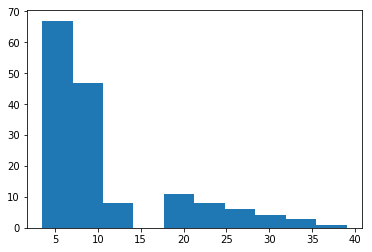

In [24]:
plt.close()
plt.hist(full_y)
plt.show()

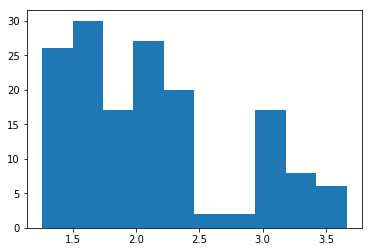

In [28]:
plt.close()
plt.hist(np.log(full_y))
plt.show()

In [30]:
print('children:',len(pheno[pheno.Age<15]),
      'young adults:', len(pheno[pheno.Age>15]))

children: 122 young adults: 33


In [104]:
pheno.AgeGroup.value_counts()

b'8-12yo'    34
b'5yo'       34
b'Adult'     33
b'7yo'       23
b'3yo'       17
b'4yo'       14
Name: AgeGroup, dtype: int64

## Extract features

In [70]:
from nilearn import datasets
parcellations = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = parcellations.scale064

In [72]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)
correlation_measure = ConnectivityMeasure(kind='correlation')

In [47]:
masker.fit_transform?

In [54]:
from scipy.io import loadmat
import h5py
# practice subject:
sub = dataset.func[0]
arrays = {}
f = h5py.File(conf)
for k, v in f.items():
    arrays[k] = np.array(v)

In [59]:
arrays['R'].shape

(29, 168)

In [73]:
time_series = masker.fit_transform(sub, confounds=arrays['R'].T)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)

In [74]:
upper_triang_corr.shape

(2016,)

In [335]:
%%time
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec

all_features = [] # here is where we will put the data (a container)
for i,sub in enumerate(dataset.func):
    # convert confounds to readable format
    arrays = {}
    f = h5py.File(dataset.confounds[i])
    for k, v in f.items():
        arrays[k] = np.array(v)
    conf = arrays['R'].T
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=conf)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # isolate non-redundant features
    upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)
    # add to our container
    all_features.append(upper_triang_corr)
    # keep track of status
    print('finished %s of %s'%(i+1,len(dataset.func)))

In [82]:
np.savez_compressed?

In [85]:
# save data so we don't have to rerun that again
outdir = os.getcwd()
np.savez_compressed(os.path.join(outdir,'BASC064_features'),a = all_features, b = full_y)

In [110]:
X = np.array(all_features)

## Create training sample to experiment with different models
* Basic model (done)
* Log_transform (done)
* More balanced ages
* Weighting adults more
* Child vs adult? (done)

#### First take out the test set for later

In [105]:
age_groups = pheno.AgeGroup

In [123]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=123)
splits = splitter.split(all_features,age_groups)

In [124]:
for train_index, test_index in splits:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = full_y[train_index], full_y[test_index]
    ageGroup_train, ageGroup_test = age_groups[train_index], age_groups[test_index]

In [134]:
print('training:', len(X_train),
     'testing:', len(X_test))

training: 93 testing: 62


In [130]:
ageGroup_train.value_counts() / len(ageGroup_train)

b'Adult'     0.215054
b'8-12yo'    0.215054
b'5yo'       0.215054
b'7yo'       0.150538
b'3yo'       0.107527
b'4yo'       0.096774
Name: AgeGroup, dtype: float64

In [131]:
ageGroup_test.value_counts() / len(ageGroup_test)

b'5yo'       0.225806
b'8-12yo'    0.225806
b'Adult'     0.209677
b'7yo'       0.145161
b'3yo'       0.112903
b'4yo'       0.080645
Name: AgeGroup, dtype: float64

#### Let's just run a regular old model with cross-validation on the training set

In [332]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score

rf = RandomForestRegressor(n_estimators=20, random_state=123)
y_pred = cross_val_predict(rf, X_train, y_train, groups=ageGroup_train, cv=10)
r2_score = cross_val_score(rf, X_train, y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(rf, X_train, y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

In [160]:
list(zip(r2_score,mae_score))

[(-1.8255977558510836, -2.7518500684150005),
 (0.39280026944891344, -4.15383032158),
 (0.7291880992353247, -4.016434051999999),
 (0.20557814903847393, -3.3637206251500005),
 (0.15511386445337838, -8.605169290483333),
 (0.6174592096381848, -4.6535766598277775),
 (-0.13450146643419658, -6.491634306838888),
 (0.5417873630703542, -3.680270476888888),
 (-0.2437434308711608, -1.8550974979666661),
 (0.4938851965336654, -4.010787208155555)]

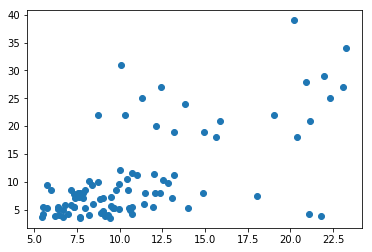

r2 =  -0.8042372262752491 "real" r2 =  0.42037556227863077 mae =  4.335090849545699


In [333]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
plt.close()
plt.scatter(y_pred, y_train)
plt.show()

print('r2 = ',r2_score(y_pred,y_train),
      '"real" r2 = ', pearsonr(y_pred,y_train)[0]**2,
     'mae = ',mean_absolute_error(y_pred,y_train))

#### What if we log-transform age

In [198]:
log_y_train = np.log(y_train)

In [186]:
y_pred = cross_val_predict(rf, X_train, log_y_train, groups=ageGroup_train, cv=10)
r2 = cross_val_score(rf, X_train, log_y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(rf, X_train, log_y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

In [187]:
list(zip(r2,mae_score))

[(-0.41481439700494294, -0.32153886311435975),
 (0.47072151786691185, -0.4037805517049028),
 (0.5577158014410151, -0.35220518564108455),
 (0.26169422325472813, -0.27761017597442794),
 (0.26554800923425803, -0.6509614481244498),
 (0.39453470109589583, -0.41193064817009467),
 (0.1835883715786355, -0.4589371530827005),
 (0.460283282002008, -0.3592292041080869),
 (-0.033268456073531905, -0.30492487465717777),
 (0.5428618117763904, -0.3541124012249057)]

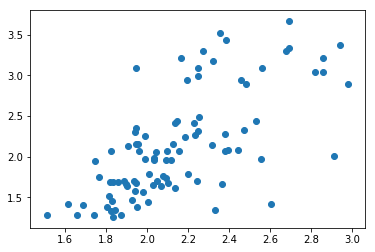

r2 =  -1.3208205374405941 "real" r2 =  0.4579850096189085 mae =  0.3885440769105384


In [188]:
plt.close()
plt.scatter(y_pred, np.log(y_train))
plt.show()

print('r2 = ',r2_score(y_pred,log_y_train),
      '"real" r2 = ', pearsonr(y_pred,log_y_train)[0]**2,
     'mae = ',mean_absolute_error(y_pred,log_y_train))

In [200]:
np.exp(mean_absolute_error(y_pred,log_y_train))

1.4748319880697072

#### Looking good. Let's give it a shot on the test sample!

In [211]:
# transform testing set based on training distribution...
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log).fit(y_train.values.reshape(-1,1))
log_y_test = transformer.transform(y_test.values.reshape(-1,1))[:,0]

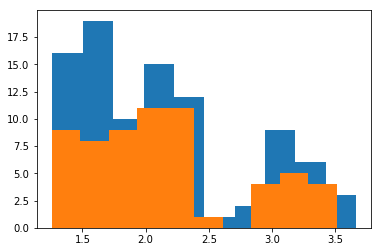

In [214]:
plt.close()
plt.hist(log_y_train)
plt.hist(log_y_test)
plt.show()

In [217]:
rf.score?

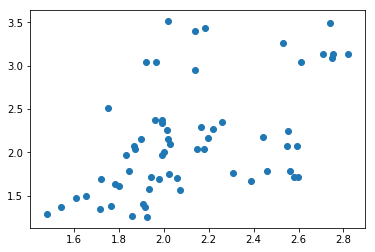

r2 =  0.27295115532004866 mae =  0.4231724816483632


In [220]:
# run it!
rf.fit(X_train, log_y_train)
y_pred = rf.predict(X_test)
r2 = rf.score(X_test, log_y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=log_y_test)

plt.close()
plt.scatter(y_pred, log_y_test)
plt.show()

print('r2 = ',r2,
     'mae = ', mae)

In [222]:
np.exp(0.4231724816483632)

1.5267976178265494

#### Okay well it's not mind blowing but it's something!

## Have a look at feature importances

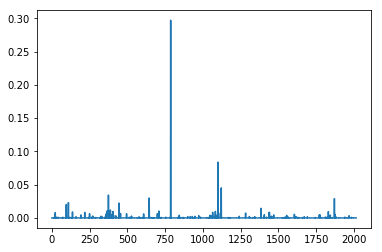

In [225]:
plt.close()
plt.plot(rf.feature_importances_)
plt.show()

In [227]:
#from nilearn import plotting
plotting.find

In [268]:
feat_exp_matrix = np.zeros((64,64))
upper_tri_coord = np.triu_indices_from(feat_exp_matrix,1)
feat_exp_matrix[upper_tri_coord] = rf.feature_importances_
feat_exp_matrix.T[upper_tri_coord] = feat_exp_matrix[upper_tri_coord]


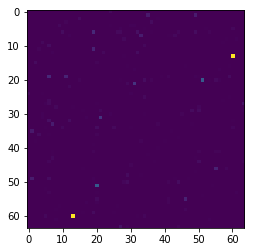

In [269]:
plt.close()
plt.imshow(feat_exp_matrix)
plt.show()

In [265]:
coords = []
from nilearn import image
from nibabel import Nifti1Image
img = image.load_img(atlas_filename)
atlas_data = img.get_data()
aff = img.affine
mask1 = np.zeros_like(atlas_data)
mask1[atlas_data==13] = 1.0
mask2 = np.zeros_like(atlas_data)
mask2[atlas_data==60] = 1.0
x1,y1,z1 = plotting.find_xyz_cut_coords(Nifti1Image(mask1,aff))
# x1,y1,z1 = plotting.find_xyz_cut_coords(Nifti1Image(img.get_data().astype(float),aff),
#                                        Nifti1Image(mask1,aff))
# x2,y2,z2 = plotting.find_xyz_cut_coords(img,
#                                        Nifti1Image(mask2,aff))

In [266]:
x1,y1,z1

(-45.36752136752137, 20.363247863247864, 21.65811965811966)

In [267]:
coords = []
img = image.load_img(atlas_filename)
atlas_data = img.get_data()
aff = img.affine
for i in range(1,65):
    roi = np.zeros_like(atlas_data)
    roi[atlas_data==i] = 1.0
    coords.append(plotting.find_xyz_cut_coords(Nifti1Image(roi,aff)))

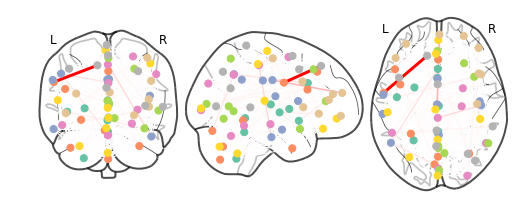

In [270]:
plt.close()
plotting.plot_connectome(feat_exp_matrix, coords)
plt.show()

In [313]:
hot_rois = set(np.sort(np.where(feat_exp_matrix>0.02)[0]))
#hot_coords = [coords[x] for x in range(len(coords)) if x in hot_rois]
hot_values = feat_exp_matrix[np.ix_(list(hot_rois), list(hot_rois))]

#### What if we drop that really important feature?

In [317]:
feat_index = np.argmax(rf.feature_importances_)
rf.feature_importances_[feat_index]

0.2971462671126093

In [320]:
new_X_train = np.array(X_train, copy=True)
new_X_train[:,feat_index] = np.zeros(new_X_train.shape[0])

new_X_test = np.array(X_test, copy=True)
new_X_test[:,feat_index] = np.zeros(new_X_test.shape[0])

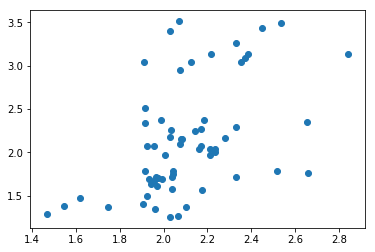

r2 =  0.2309233310863679 mae =  0.4381794269399771


In [322]:
rf.fit(new_X_train, log_y_train)
y_pred = rf.predict(new_X_test)
r2 = rf.score(new_X_test, log_y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=log_y_test)

plt.close()
plt.scatter(y_pred, log_y_test)
plt.show()

print('r2 = ',r2,
     'mae = ', mae)

## What about predicting adults vs children?

In [327]:
ageGroup_train.unique()

array([b'5yo', b'7yo', b'8-12yo', b'4yo', b'3yo', b'Adult'], dtype=object)

In [328]:
y_class_train = [1 if x==b'Adult' else 0 for x in ageGroup_train]
y_class_test = [1 if x==b'Adult' else 0 for x in ageGroup_test]

In [331]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20, random_state=123)
rfc.fit(X_train, y_class_train)
y_pred = rfc.predict(X_test)
acc = rfc.score(X_test,y_class_test)
ppv = metrics.precision_score(y_pred=y_pred,y_true=y_class_test)

print('accuracy =', acc)
print('positive predictive value = ', ppv)

accuracy = 0.7903225806451613
positive predictive value =  0.5


# Gael suggests using a linear model instead

### Cross-validation in training set

In [342]:
from sklearn.svm import SVR

l_svr = SVR(kernel='linear')
y_pred = cross_val_predict(l_svr, X_train, y_train, groups=ageGroup_train, cv=10)
r2 = cross_val_score(l_svr, X_train, y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

In [343]:
list(zip(r2,mae_score))

[(-2.8063834093341904, -3.1741615851308635),
 (0.7303516957264617, -3.245861722294746),
 (0.7837032595820714, -3.695593936165263),
 (0.6474157256466821, -2.507418459047498),
 (0.5040674706027404, -6.44007335417999),
 (0.7328753578873007, -3.9530314307046694),
 (0.6621600561435284, -4.28968022485963),
 (0.4793787914920883, -4.433794274366331),
 (-5.741562084362573, -3.6567880701972513),
 (0.6054352631397157, -3.3291715681397545)]

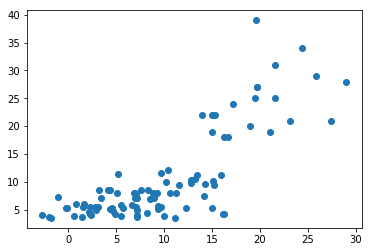

r2 =  0.5071460710279329 "real" r2 =  0.6307317872782939 mae =  3.8564063319286546


In [344]:
plt.close()
plt.scatter(y_pred, y_train)
plt.show()

print('r2 = ',r2_score(y_pred,y_train),
      '"real" r2 = ', pearsonr(y_pred,y_train)[0]**2,
     'mae = ',mean_absolute_error(y_pred,y_train))

In [345]:
l_svr = SVR(kernel='linear')
y_pred = cross_val_predict(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
r2 = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

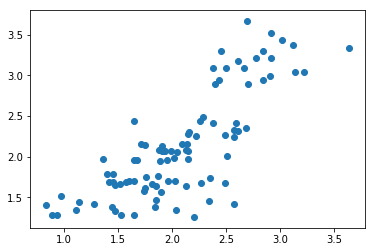

r2 =  0.4938323029099403 "real" r2 =  0.6209069534773799 mae =  0.3171767357183989


In [346]:
plt.close()
plt.scatter(y_pred, log_y_train)
plt.show()

print('r2 = ',r2_score(y_pred,log_y_train),
      '"real" r2 = ', pearsonr(y_pred,log_y_train)[0]**2,
     'mae = ',mean_absolute_error(y_pred,log_y_train))

### Testing!!!

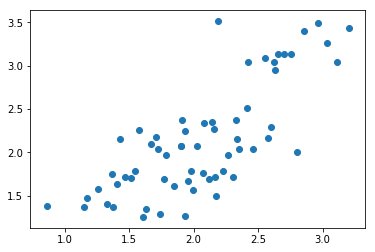

r2 =  0.5645052266954728 mae =  0.35719953873825666


In [356]:
l_svr.fit(X_train, log_y_train)
y_pred = l_svr.predict(X_test)
r2 = l_svr.score(X_test, log_y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=log_y_test)

plt.close()
plt.scatter(y_pred, log_y_test)
plt.show()

print('r2 = ',r2,
     'mae = ', mae)